## Интеллектуальный анализ данных – весна 2024
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html).

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования. Используйте [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [ ]:

from sklearn.preprocessing import OneHotEncoder

if X.isnull().sum().sum():
    X.dropna(inplace=True)


categorical_cols = X.select_dtypes(include=['object']).columns

if not categorical_cols.empty:
    encoder = OneHotEncoder()
    encoded = pd.DataFrame(encoder.fit_transform(X[categorical_cols]).toarray(), columns=encoder.get_feature_names(categorical_cols))
    X.drop(categorical_cols, axis=1, inplace=True)
    X = pd.concat([X, encoded], axis=1)



**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

Используйте аргумент `stratify` при разбиении. Почему это важно?

In [ ]:
from typing import Any
from sklearn.model_selection import train_test_split
np.random.seed(123456)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

**Мы используем stratify чтобы пропорция классов на треин и тесте была примерно равной. Все для того, чтобы на обучении нам хватало представителей каждого класса**

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['alcohol', 'magnesium']])
X_test_scaled = scaler.transform(X_test[['alcohol', 'magnesium']])


In [ ]:
classifiers = []
for k in [1, 3, 5, 10, 15, 25]:
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifiers.append(classifier.fit(X_train_scaled, y_train))

    train_accuracy = accuracy_score(y_train, classifier.predict(X_train_scaled))
    test_accuracy = accuracy_score(y_test, classifier.predict(X_test_scaled))

    print(f"KNeighbors Classifier with k={k}:")
    print(f"Training accuracy: {train_accuracy:.2f}")
    print(f"Test accuracy: {test_accuracy:.2f}")
    print()



KNeighbors Classifier with k=1:
Training accuracy: 1.00
Test accuracy: 0.63

KNeighbors Classifier with k=3:
Training accuracy: 0.81
Test accuracy: 0.65

KNeighbors Classifier with k=5:
Training accuracy: 0.80
Test accuracy: 0.74

KNeighbors Classifier with k=10:
Training accuracy: 0.74
Test accuracy: 0.78

KNeighbors Classifier with k=15:
Training accuracy: 0.73
Test accuracy: 0.72

KNeighbors Classifier with k=25:
Training accuracy: 0.72
Test accuracy: 0.72



**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/).

In [ ]:
!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [ ]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов.
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново.
6. Построение графика может занять некоторое время – придётся немного подождать!

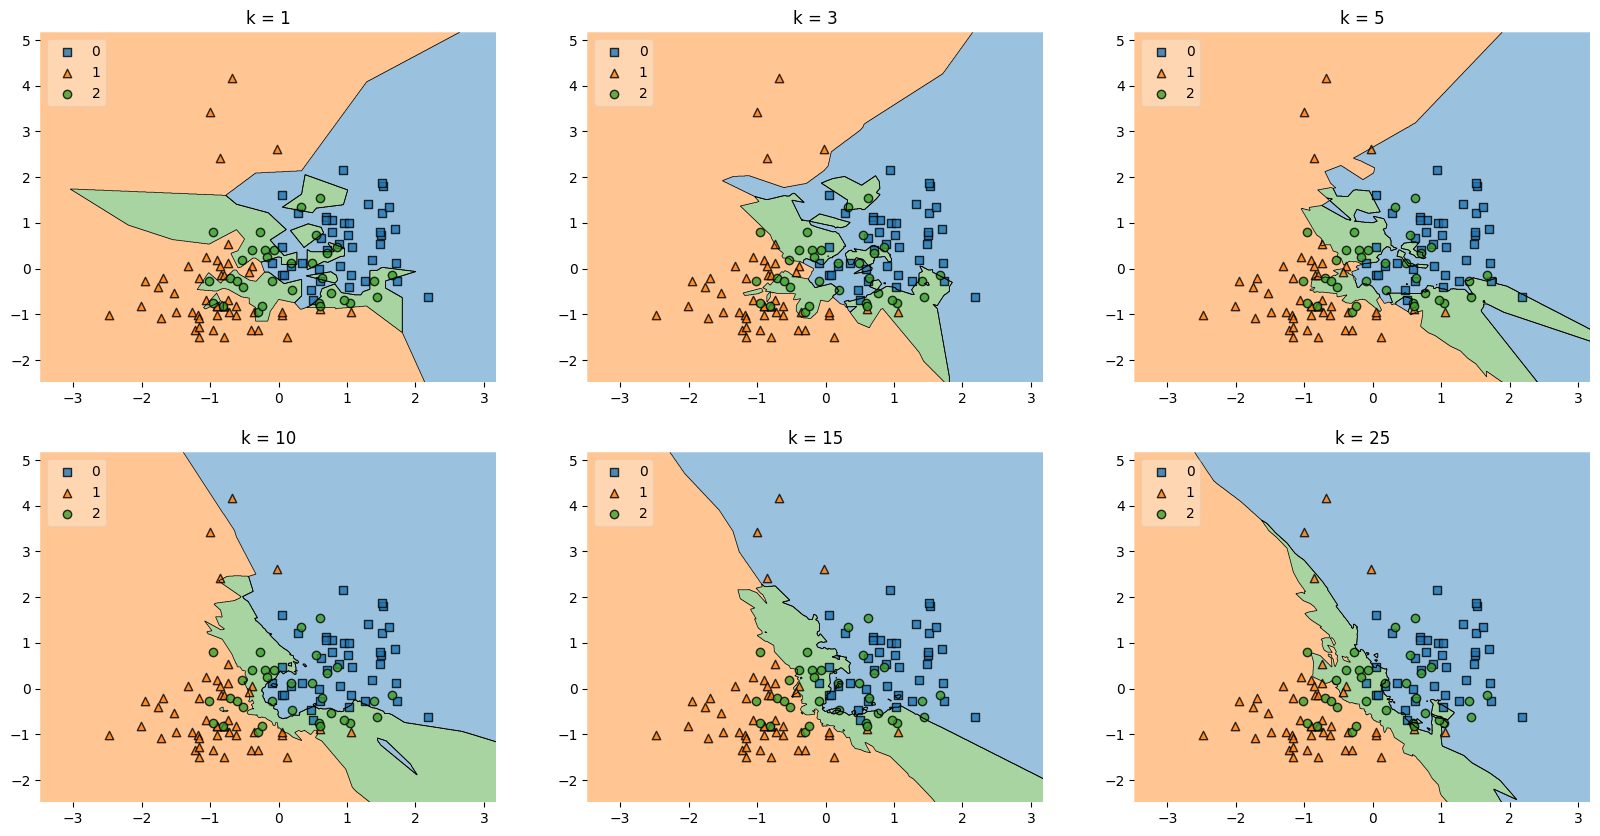

In [ ]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools
gs = gridspec.GridSpec(2, 3)

fig = plt.figure(figsize=(20,10))

labels = ['k = 1', 'k = 3', 'k = 5', 'k = 10', 'k = 15', 'k = 25']
for clf, lab, grd in zip(classifiers,
                         labels,
                         itertools.product([0, 1, 2], repeat=2)):

    clf.fit(X_train_scaled, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train_scaled, y=y_train, clf=clf, legend=2)
    plt.title(lab)

plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности. Какие из результатов явно говорят о переобучении модели? Почему?

Для малых k по картинке видно, что модель переобучается из-за наличия отдельных островков, нет плавного разделения, слишком сильно реагирует на отклоняющиеся элементы. Вот для k от 10 картинка ужке лучше, меньше реакции на выбросы, но при увеличении k синяя область захватывает оранживаю и все становится хуже. Ну и по точности k = 10 выигрывает, так что это наиболее оптимальный вариант

### Задание 2. KNN своими руками. 2 Балла

В данном задании мы попробуем реализовать алгоритм KNN своими руками. В данном случае мы попробуем сделать KNN для классификации.

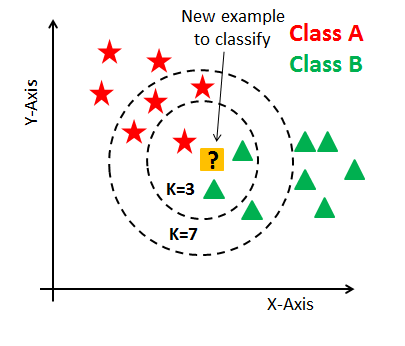

In [ ]:
import numpy as np
from collections import Counter
from scipy.spatial import distance
class KNN:
    def __init__(self, k):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        distances = distance.cdist(X_test, self.X_train, 'euclidean')
        indices = distances.argsort(axis=1)[:, :self.k]
        nearest_labels = self.y_train[indices]
        predictions = np.array([np.bincount(labels).argmax() for labels in nearest_labels])
        return predictions

In [ ]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [ ]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

**Почему-то этот файл у меня не нашелся, так что снова грузим его с кагла((((**

In [ ]:
! pip install opendatasets
! pip install pandas

In [ ]:
import opendatasets as od
import pandas

od.download(
    "https://www.kaggle.com/datasets/shivam2503/diamonds")

Skipping, found downloaded files in "./diamonds" (use force=True to force download)


In [ ]:

file =('/content/diamonds/diamonds.csv')
data = pd.read_csv(file)

data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.2 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их.
Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [ ]:
print(f'Пропущенных значений: {data.isnull().sum().sum()}')
data = data.drop('Unnamed: 0',axis=1)
data.head()

Пропущенных значений: 0


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


**Задача 3.2 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [ ]:
data.corr()

<ipython-input-229-c44ded798807>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


**Больше всего с целовой переменной коррелируют carat, x, y, z**

**Задача 3.3 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder_df = pd.DataFrame(encoder. fit_transform(data[['cut','color','clarity']]). toarray ())
data = data.join (encoder_df)
data = data.drop(['cut','color','clarity'],axis = 1)
data.head()

,carat,depth,table,price,x,y,z,0,1,2,...,10,11,12,13,14,15,16,17,18,19
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


**Задача 3.4 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3. Не забудьте про параметр `stratify`.

In [ ]:
np.random.seed(123456890)
y_d = data['price']
bins = np.linspace(0, 2800, 700)
y_binned = np.digitize(y_d, bins)
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(data, y_d, test_size = 0.3, stratify=y_binned)
X_train_d = X_train_d.drop('price',axis = 1)
X_test_d = X_test_d.drop('price',axis = 1)


**Задача 3.5 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [ ]:
scaler = StandardScaler()
X_train_scaled_d = np.concatenate(( X_train_d.drop(['carat','depth','table','x','y','z'],axis = 1), scaler.fit_transform(X_train_d[['carat','depth','table','x','y','z']])), axis=1)
X_test_scaled_d = np.concatenate(( X_test_d.drop(['carat','depth','table','x','y','z'],axis = 1), scaler.fit_transform(X_test_d[['carat','depth','table','x','y','z']])), axis=1)


**Задача 3.6 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
lr = LinearRegression().fit(X_train_scaled_d, y_train_d)
print(f"Train: {mean_squared_error(y_train_d, lr.predict(X_train_scaled_d))}")
print(f"Test: {mean_squared_error(y_test_d, lr.predict(X_test_scaled_d))}")

Train: 1296551.8281657612
Test: 1240159.847409303


**Задача 3.7 (0.2 балла)** Изучите [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [ ]:
lr.coef_

array([ 3.16356510e+14,  3.16356510e+14,  3.16356510e+14,  3.16356510e+14,
        3.16356510e+14,  8.34798619e+02,  6.24008241e+02,  5.61265651e+02,
        3.58290817e+02, -1.43480926e+02, -6.50824276e+02, -1.58222519e+03,
       -3.86243165e+03,  1.54651246e+03, -1.45485517e+02, -1.12538933e+03,
        7.87538776e+02,  4.49068359e+02,  1.20612500e+03,  1.14360742e+03,
        5.33590625e+03, -7.15625000e+01, -5.95312500e+01, -1.09139062e+03,
        9.55468750e+01, -1.30484375e+02])

**Первые 6 значений как раз оценки коэффициентов вещественных переменных (как в таблице). Получаем, что оценка коэффициентов вещественной переменной "z", равная 8.34798619e+02, по модулю на порядок меньше оценки прочих вещественных переменных (а именно carat	depth	table	price	x	y, вот они и имеют наибольший ыес)**

**Задача 3.8 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией.

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [ ]:
from sklearn.linear_model import Lasso, Ridge
lasso = Lasso(10.0).fit(X_train_scaled_d, y_train_d)
ridge = Ridge(10.0).fit(X_train_scaled_d, y_train_d)
print(f'lasso:{lasso.coef_}')
print(f'ridge:{ridge.coef_}')

lasso:[ -470.08294671   -29.40256776    89.15162639     0.
     0.           329.05727248   157.55046409   107.85877782
    -0.          -443.06782577  -882.71084051 -1709.74504927
 -3606.10929256   700.16608822  -623.36901601 -1541.03041354
   180.71889666   -20.63777513   531.69672511   519.93825512
  4863.25027798   -83.44113535   -77.43972768  -602.80521308
    -0.          -125.30750771]
ridge:[ -601.94199682     5.5024922    257.22633315   188.2960561
   150.91711537   829.8292609    620.02588881   557.55106658
   356.40276648  -144.34046008  -647.95999187 -1571.50853083
 -3787.95939663  1526.45638375  -153.73212476 -1129.04953719
   777.24359604   440.35782626  1193.96998699  1132.71326555
  5295.97382873   -68.69979506   -59.604352   -1030.02747069
    87.02684532  -147.26513533]


**Как мы видим, веса ЗНАЧИТЕЛЬНО уменьшились, пропали бешеные 14 степени и жизнь наладилась. Так что проблема мультиколлинеарности в изначальной регрессии была немыслимой**

**Задача 3.9 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов.

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.522e+07, tolerance: 6.076e+07
  model = cd_fast.enet_coordinate_descent(


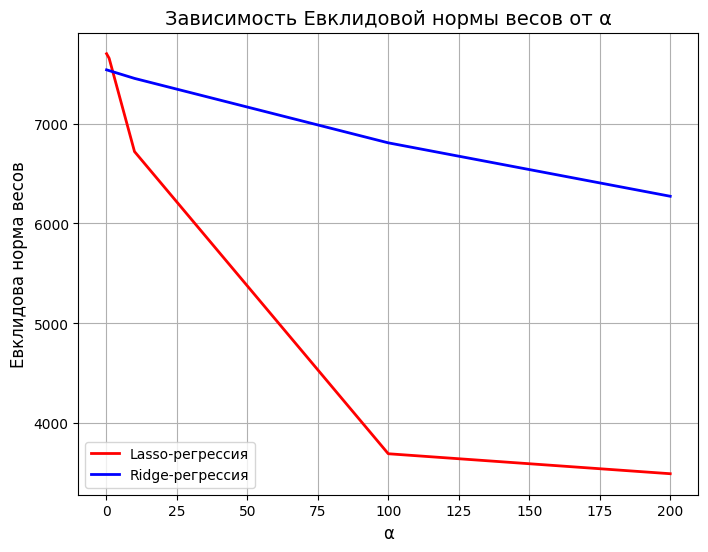

In [ ]:
plt.figure(figsize=(8, 6))
par = [0.1, 1, 10, 100, 200]
e_norm_l = []
e_norm_r = []
for k in par:
    ls = Lasso(k).fit(X_train_scaled_d, y_train_d)
    rg = Ridge(k).fit(X_train_scaled_d, y_train_d)
    e_norm_l.append(np.linalg.norm(ls.coef_))
    e_norm_r.append(np.linalg.norm(rg.coef_))
plt.grid(True)
plt.plot(par,e_norm_l,label = 'Lasso-регрессия',color='red',linewidth = 2)
plt.plot(par,e_norm_r,label = 'Ridge-регрессия',color='blue',linewidth = 2)
plt.xlabel('α',fontsize =12)
plt.ylabel('Евклидова норма весов', fontsize =12)
plt.title('Зависимость Евклидовой нормы весов от α', fontsize = 14)
plt.legend(loc = 'lower left')

Из графика очевидно, что Лассо-регрессия агрессивнее уменьшает веса. Ее удобнее использовать для отбора признаков, тк она уменьшает вес незначительных признаков до нуля, что очень удобно при большом количестве признаков

**Задача 3.10 (0.5 балла)**
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке.

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`.

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество.

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold

reg = LassoCV(alphas =[0.1, 1, 10, 100, 200], cv=5).fit(X_train_scaled_d,y_train_d)
ms = reg.mse_path_
res = []
for el in ms:
    res.append(np.mean(el))
print(f' Усреднённое MSE для α = 0.1: {res[4]}')
print(f' Усреднённое MSE для α = 1: {res[3]}')
print(f' Усреднённое MSE для α = 10: {res[2]}')
print(f' Усреднённое MSE для α = 100: {res[1]}')
print(f' Усреднённое MSE для α = 200: {res[0]}')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1808510487.9622498, tolerance: 48846911.44971824
  model = cd_fast.enet_coordinate_descent_gram(


 Усреднённое MSE для α = 0.1: 1301518.3450784988
 Усреднённое MSE для α = 1: 1300180.787273568
 Усреднённое MSE для α = 10: 1336924.0986546904
 Усреднённое MSE для α = 100: 2267860.877187047
 Усреднённое MSE для α = 200: 2475879.4108841578


**Наилучшее качество дает а=1**

**Задача 3.11 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [ ]:
las = Lasso(1).fit(X_train_scaled_d, y_train_d)
las.coef_

array([ -726.52883465,  -134.33632207,   102.33430782,    28.73633468,
           0.        ,   462.16109261,   255.39236805,   193.88548746,
           0.        ,  -495.80259262,  -996.51162141, -1917.5304995 ,
       -4333.46608464,   967.2748956 ,  -687.96849742, -1661.75943414,
         232.57600016,   -92.70421591,   643.67437441,   586.36431968,
        5293.48768182,   -77.38855973,   -61.19196764,  -992.27648626,
           0.        ,   -99.31884002])

Из вещественных коэф наиболее значительным оказался carat, остальные достаточно незначительные, особенно х и у. Также видим признаки с весом -1917, -4333, 5293. Смысловое объяснение этого результата может быть связано с тем, что Lasso-регрессия штрафует модель за большое количество параметров, поэтому ряд признаков получил нулевые коэффициенты, что означает, что они могут быть исключены из модели без ущерба для качества ее предсказаний.

**Задача 3.12 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [ ]:
print(f"Test: {mean_squared_error(y_test_d, las.predict(X_test_scaled_d))}")
print(f"Test before: {1240159.847409303}")

Test: 1238054.7536262865
Test before: 1240159.847409303


Все же лассо-регрессия оказалось лучше, так как ошибка меньше.
Причины, почему лассо лучше:
1. Lasso-регрессия включает в себя штраф за сложность модели и "удаляет" неинформативные признаки
2. Решает проблему мультиколлинеарности, которая до этого у нас наблюдалась